In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown,display
import datetime
import time
import re
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score




asset_directory = "data/data_asset_choosed/487_None"
file_name = "data/data_asset_choosed/487_None/487_51.csv"
df_ride = pd.read_csv(file_name,parse_dates=[1])
df['category'] = (df['delay']>20 ).apply(lambda x: int(x))
df_ride.head(10)

/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,asset,recorded_at,MDI_OBD_SPEED,GPS_SPEED,MDI_OBD_RPM,MDI_OBD_ENGINE_LOAD,MDI_OBD_FUEL,ODO_FULL_METER,MDI_DASHBOARD_MILEAGE,distance_meter,...,avrg_speed,acceleration,distance_speed,distance_cum,delay,fuel,filled_speed,filled_meter,filled_load,filled_rpm
0,487,2017-10-15 18:49:03,NaN,55992.0,NaN,NaN,3618573.0,5063840.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
1,487,2017-10-15 18:49:05,105.0,55529.0,2458.0,NaN,3618587.0,NaN,NaN,NaN,...,NaN,NaN,58.333333,58.333333,2.0,NaN,False,False,False,False
2,487,2017-10-15 18:49:06,NaN,55282.0,NaN,NaN,NaN,NaN,NaN,NaN,...,105.000000,NaN,29.166667,87.500000,1.0,NaN,True,False,True,True
3,487,2017-10-15 18:49:08,104.0,55286.0,NaN,NaN,3618601.0,5063952.0,NaN,NaN,...,105.000000,1.0,57.777778,145.277778,2.0,14.0,False,False,True,True
4,487,2017-10-15 18:49:10,105.0,55429.0,2437.0,NaN,3618615.0,NaN,NaN,NaN,...,104.500000,-1.0,58.333333,203.611111,2.0,14.0,False,True,True,False
5,487,2017-10-15 18:49:11,NaN,55337.0,NaN,NaN,NaN,5064064.0,NaN,112.0,...,104.666667,NaN,29.166667,232.777778,1.0,14.0,True,False,True,True
6,487,2017-10-15 18:49:13,106.0,55534.0,NaN,NaN,3618629.0,NaN,NaN,112.0,...,104.666667,-1.0,58.888889,291.666667,2.0,14.0,False,True,True,True
7,487,2017-10-15 18:49:15,NaN,55417.0,2453.0,NaN,3618636.0,NaN,NaN,NaN,...,105.000000,NaN,58.888889,350.555556,2.0,7.0,True,False,True,False
8,487,2017-10-15 18:49:17,105.0,55550.0,NaN,NaN,3618647.0,5064176.0,NaN,112.0,...,105.000000,1.0,58.333333,408.888889,2.0,11.0,False,False,True,True
9,487,2017-10-15 18:49:18,NaN,55660.0,NaN,NaN,NaN,NaN,NaN,112.0,...,105.000000,NaN,29.166667,438.055556,1.0,11.0,True,True,True,True


In [5]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
data.head()

,Weight,Feed,Time,Pig,Evit,Cu,Litter
0,26.50000,NaN,1,4601,1,1,1
1,27.59999,5.200005,2,4601,1,1,1
2,36.50000,17.600000,3,4601,1,1,1
3,40.29999,28.500000,4,4601,1,1,1
4,49.09998,45.200001,5,4601,1,1,1


/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   fuel       
No. Observations:   29759     Method:               REML       
No. Groups:         39        Scale:                0.0000     
Min. group size:    123       Likelihood:           140631.8138
Max. group size:    4839      Converged:            Yes        
Mean group size:    763.1                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.994    0.241  4.116 0.000  0.521  1.467
PC                   -2.026    0.258 -7.858 0.000 -2.531 -1.521
Intercept RE          2.271   50.755                           
Intercept RE x PC RE  1.137                                    
PC RE                 2.590                                    



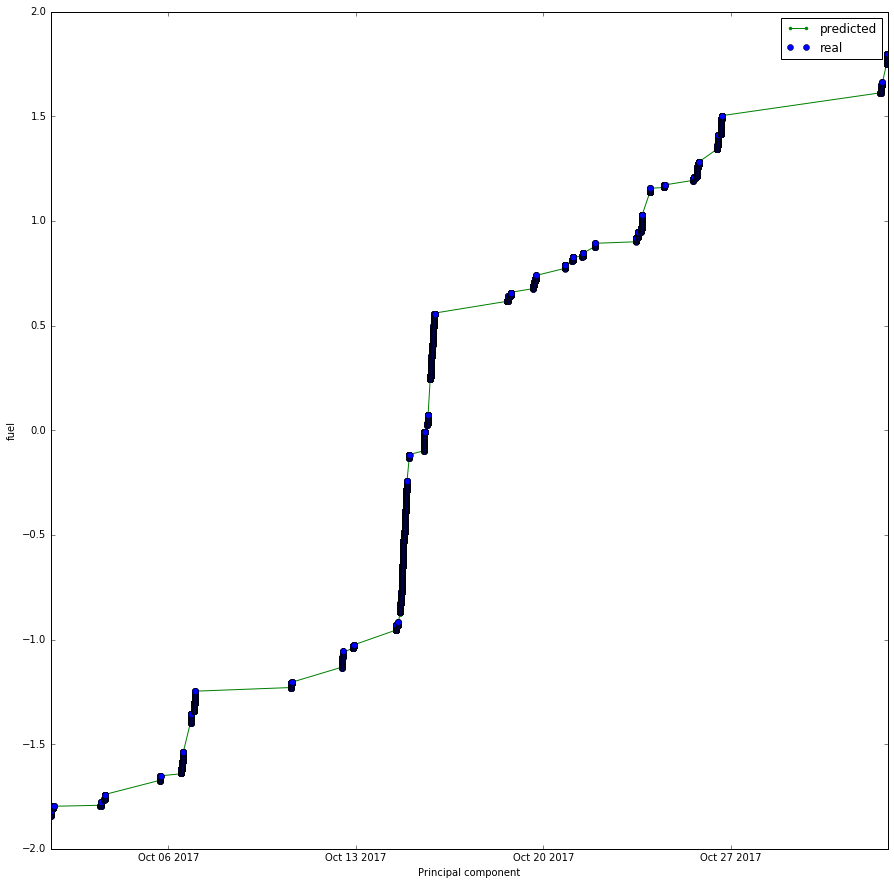

In [95]:
#Statsmodel
#With min max scaling
def min_max_format(df):
    min_max_scaler = preprocessing.StandardScaler()
    df = df[~np.isnan(df['MDI_OBD_FUEL'])& ~np.isnan(df['meter_filled']) & ~np.isnan(df['speed_filled'])]
    X = pd.DataFrame(min_max_scaler.fit_transform(df[['meter_filled']]),index=df.index)
    pca = PCA(n_components=1)
    X = pca.fit_transform(X)
    np_scaled = min_max_scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled,index=df.index,columns=['PC'])
    time = df['recorded_at']
    y = pd.DataFrame(min_max_scaler.fit_transform(df['MDI_OBD_FUEL'].reshape(-1,1)),index=df.index)
    X['delay'] = df['delay'] 
    X['fuel'] = y
    X['group'] = df['ride']
    X['time'] =  time
    return [X,time]
def merge_sing_asset_col(asset_directory):
    First = True
    for idx,filename in enumerate(os.listdir(asset_directory)):
        name, file_extension = os.path.splitext(asset_directory+"/"+filename)
        if file_extension=='.csv':
            df=pd.read_csv(asset_directory+"/"+filename,parse_dates=[1],na_values=' ')
            if( (len(df)>200) & (len(df[np.isnan(df['MDI_OBD_FUEL'])])/len(df)<0.5) & (len(df[np.isnan(df['MDI_OBD_SPEED'])])/len(df)<0.5)):#Condition: file big enough with enough fuel and distance information
                df['ride'] = pd.Series(np.full(len(df),idx), index=df.index)
                df['category'] = ((df['delay']>20 )).apply(lambda x: int(x)) 
                df['group'] = df['ride']*10 + df['category']
                if (First):
                    merged = df
                    First = False
                else:
                    merged = merged.append(df,ignore_index=True)                
    return merged

df_asset = merge_sing_asset_col(asset_directory) 
df_asset.head(10)

data = min_max_format(df_asset)[0]
time = min_max_format(df_asset)[1]
data.head(10)
md = smf.mixedlm('fuel ~ PC',data, groups=data['group'],re_formula="~PC")
mdf = md.fit()
print(mdf.summary())
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
plt.ylabel('fuel')
plt.xlabel('Principal component')
ax.plot(data['time'],mdf.fittedvalues, 'g.-',label="predicted")
ax.plot(data['time'],data['fuel'], 'o',label="real")
ax.legend(loc="best")
plt.savefig("mixed_linear_model.pdf")

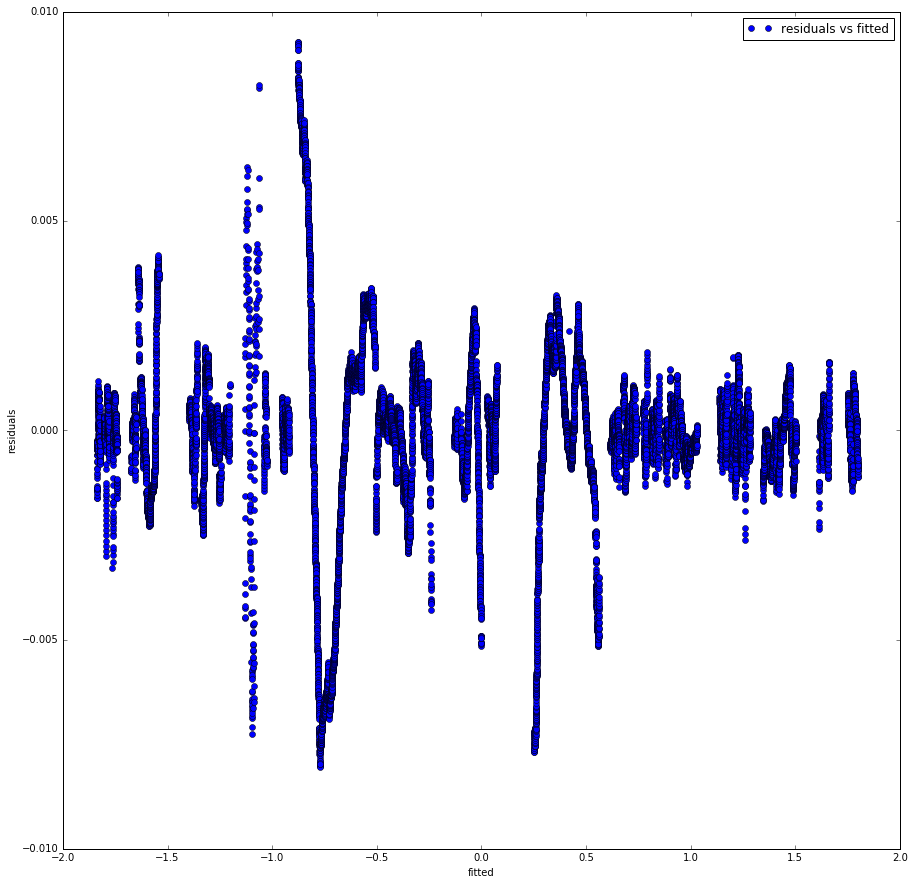

In [96]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
plt.ylabel('residuals')
plt.xlabel('fitted')
ax.plot(mdf.fittedvalues,mdf.resid, 'o',label="residuals vs fitted")
ax.legend(loc="best")

/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/homes/wsahel/.local/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to con

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    fuel     
No. Observations:      4839       Method:                REML     
No. Groups:            2          Scale:                 0.0180   
Min. group size:       54         Likelihood:            2833.0867
Max. group size:       4785       Converged:             No       
Mean group size:       2419.5                                     
------------------------------------------------------------------
                        Coef. Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.090                                     
PC                      1.029    0.002 512.558 0.000  1.025  1.033
Intercept RE            0.027                                     
Intercept RE x delay RE 0.006                                     
delay RE                0.002                                     



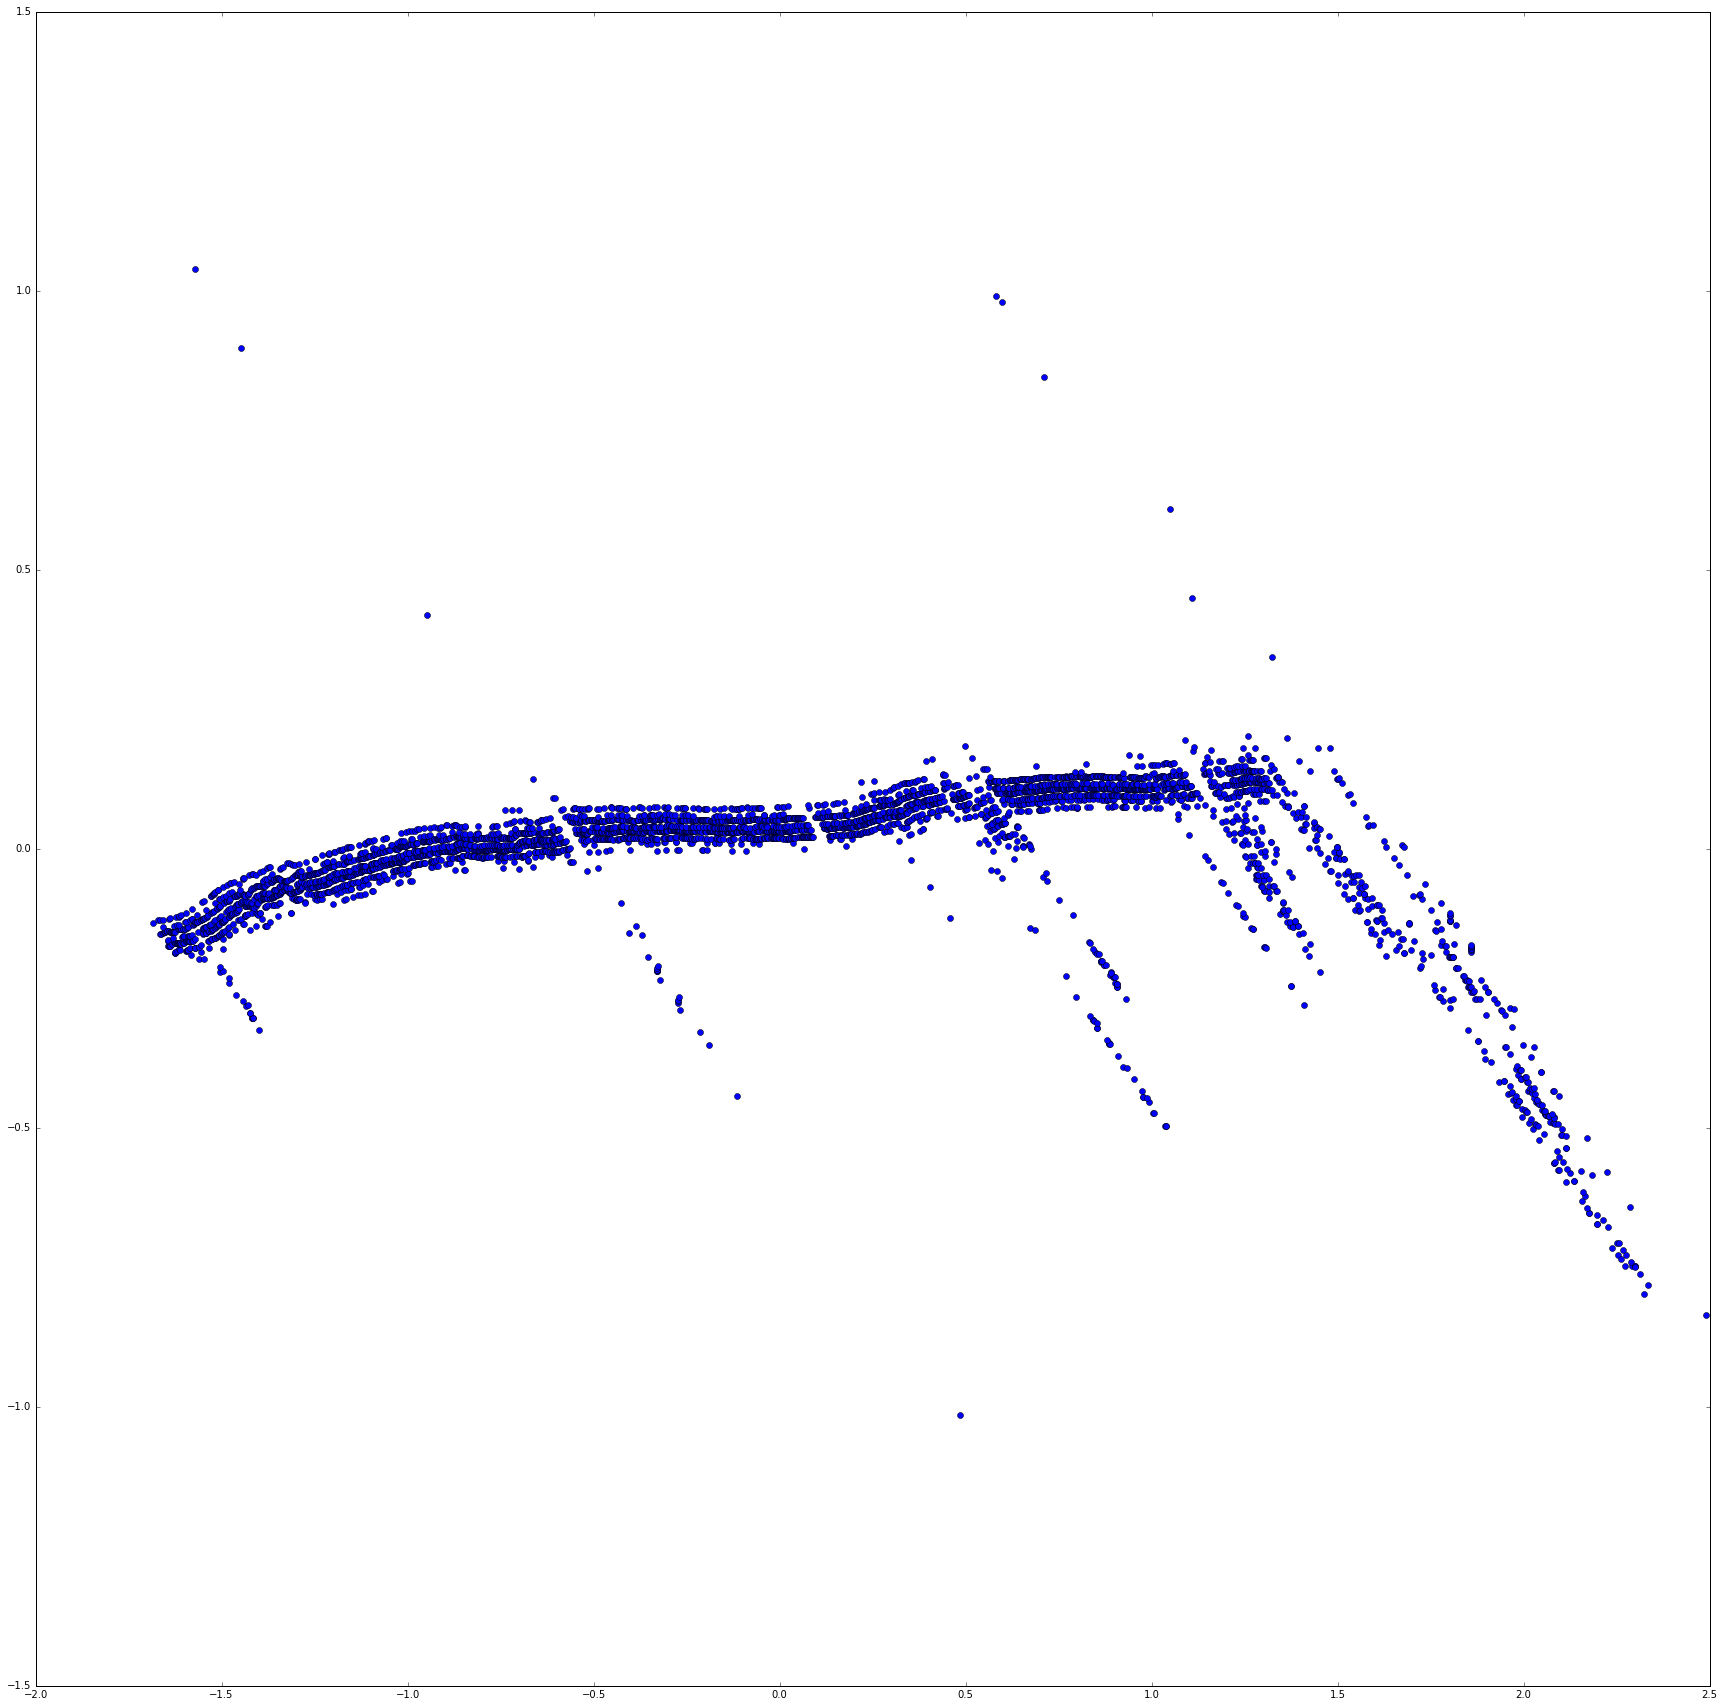

In [63]:
df_ride = pd.read_csv(file_name,parse_dates=[1])
df_ride['group'] = (df_ride['delay']>20 ).apply(lambda x: int(x))
data = min_max_format(df_ride)[0]
time = min_max_format(df_ride)[1]
data.head(10)
md = smf.mixedlm('fuel ~ PC',data, groups=data['group'],re_formula="~delay")
mdf = md.fit()
print(mdf.summary())
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(mdf.fittedvalues,mdf.resid, 'o',label="residuals vs fitted")
plt.savefig("mixed_linear_model.pdf")